In [1]:
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import pandas as pd
import numpy as np
import os

%matplotlib inline

path = '/'.join(os.getcwd().split('/')[:-2])
print(path)

/Volumes/Dropbox/largetransfer/luc/carter


//anaconda/envs/data_sci/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
tci = pd.read_csv(path+'/data/model_data/tci_2_2.csv', parse_dates=['Date'], dtype={'Parcel ID':str})
ppns = set(tci['parcel'])
ppns_num = set(tci['parcel'].apply(lambda x: x.replace('-','')))

dates = dict(zip(tci.parcel, tci.Date))

print(tci.shape)

(113132, 9)


In [3]:
fc = pd.read_csv(path+'/data/clean_data/foreclosure_filings2.csv', parse_dates=[2])

fc = fc.sort_values('filedate').groupby('caseno').last()
fc = fc.rename(columns={'filedate':'date'}).reset_index()
fc['type'] = 'fc'
fc = fc[['date','type','parcel']]


In [4]:
fc.head(2)

,date,type,parcel
0,2006-10-03,fc,107-16-046
1,2006-10-03,fc,119-01-007


In [32]:
sa = pd.read_csv(path+'/data/clean_data/sheriff_auction.csv', parse_dates=[2], encoding="ISO-8859-1")

sa = sa.sort_values('salesdt').groupby('parcel').last()
sa = sa.rename(columns={'salesdt':'date'})
sa = sa[['date']]
sa['type'] = 'sa'
sa = sa.reset_index()

In [36]:
al = pd.read_csv(path+'/data/clean_data/armslength.csv',dtype=str)
al = al.drop_duplicates()

months = dict(zip(['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'],range(1,13)))

def parse_date(x):
    day = int(x[0:2])
    month = months[x[2:5]]
    year = int(x[5:])
    return dt.datetime(year,month,day)

al['date'] = al.mdate.apply(parse_date)
# al = al[al.date < dt.datetime(2015,6,1)]

al = al.rename(columns={'PROPERTY_NUMBER':'parcel'})
al = al[['date','parcel']]
al['type'] = 'al'

In [65]:
t = pd.read_csv(path+'/data/clean_data/transfers.csv', parse_dates=['mdate'], dtype=str)
t = t[(t.DEED_TYPE.isin(['Sheriffs Deed Ex','Sheriffs Deed']))]
t = t[['PROPERTY_NUMBER','mdate']].rename(columns={'PROPERTY_NUMBER':'parcel','mdate':'date'})
t['type'] = 't'

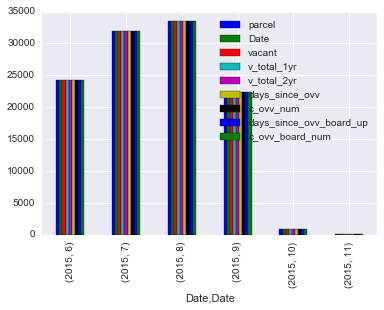

In [28]:
tci.groupby([tci.Date.dt.year, tci.Date.dt.month]).count().plot(kind="bar")

In [60]:
max(t.date), max(al.date), max(sa.date)

(Timestamp('2016-01-08 00:00:00'),
 Timestamp('2015-12-31 00:00:00'),
 Timestamp('2015-12-07 00:00:00'))

In [66]:
# df = fc.append(sa).append(al).append(t)
df = t.append(al)
df = df.sort_values('date')
# df = pd.merge(df, tci[['NAME10','SPA_NAME']], how='left', right_index=True, left_index=True)

In [67]:
df = pd.merge(df, tci[['parcel','Date']].set_index('parcel'), how='left',left_on='parcel',right_index=True)
df = df[df.date < df.Date]

In [68]:
last = df.groupby('parcel').last()

In [69]:
sub = set(last[last['type'] == 't'].index)
sum(tci[tci.parcel.isin(sub)].vacant), len(tci[tci.parcel.isin(sub)].vacant)

(1378, 5909)

In [71]:
sub = set(last[last['type'] == 'al'].index)
sum(tci[tci.parcel.isin(sub)].vacant), len(tci[tci.parcel.isin(sub)].vacant)

(4983, 48770)

In [54]:
sub = set(last[last['type'] == 'al'].index)
sum(tci[tci.parcel.isin(sub)].vacant), len(tci[tci.parcel.isin(sub)].vacant)

(3272, 42345)

In [53]:
second_last = df.groupby('parcel').nth(-2)

In [54]:
pitt_vacant = set(second_last[second_last.index.isin(sub)].index)

In [55]:
sum(tci[tci.parcel.isin(pitt_vacant)].vacant), len(tci[tci.parcel.isin(pitt_vacant)].vacant)

(1836, 5220)

In [17]:
sum(tci[tci.parcel.isin(pitt_vacant)].vacant), len(tci[tci.parcel.isin(pitt_vacant)].vacant)

(1334, 3892)

In [18]:
sum(tci.vacant)

10038

In [19]:
1334.0/ 3892

0.34275436793422404

In [56]:
temp = df[df.parcel.isin(pitt_vacant)].groupby('parcel').agg(lambda x: (x.date.iloc[-1]-x.date.iloc[-2]).days)

In [57]:
np.median(temp.date)

378.0

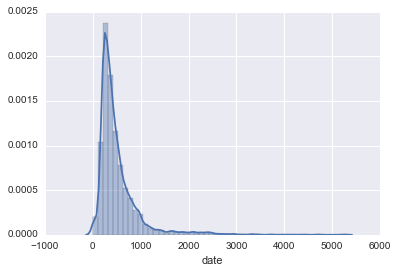

In [58]:
sns.distplot(temp.date);

In [29]:
pv = pd.read_csv(path+'/data/clean_data/postal_vacancy.csv', parse_dates=3, index_col=0)
pv.date = pv.date.apply(lambda x: dt.datetime(int(x[0:4]),int(x[5:7]),int(x[8:10])))
pv = pv.sort_values('date',ascending=False)
pv = pv.loc[pv.apply(lambda x: x.date < dates[x.PARCEL], axis=1)]

In [30]:
max(pv.date)

Timestamp('2015-10-01 00:00:00')

In [49]:
pv.groupby('date').count()

,PARCEL,vindall
date,,
2008-07-01,7551,7551
2009-08-01,6996,6996
2009-09-01,6780,6780
2010-01-01,6570,6570
2010-03-01,6667,6667
2010-05-01,6780,6780
2010-07-01,7170,7170
2010-09-01,9261,9261
2011-01-01,8613,8613


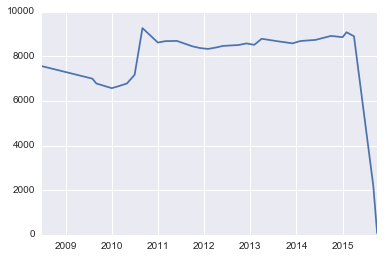

In [48]:
plt.plot(pv.groupby('date').count().index,pv.groupby('date').count().PARCEL)

In [43]:
pv = pv[pv.vindall=='Y']
pv_copy = pv.copy().groupby('PARCEL').count().reset_index()

In [59]:
pv = pv[pv.vindall=='Y']
pv_copy = pv.copy().groupby('PARCEL').count().reset_index()

pv_copy['pv_count'] = pv_copy.apply(lambda x: \
        len(pv[(pv.PARCEL == x.PARCEL) & (pv.date > dates[x.PARCEL]-pd.DateOffset(years=2))]), axis=1)

In [74]:
pv2 = pv.groupby('PARCEL').last()

In [77]:
tci[tci.parcel.isin(pv2[pv2.vindall=='Y'].index)].groupby('vacant').count()

,parcel,Date,Survey Category,Survey Grade,propsize,totusabl,tmktval,condition13,condition14,condition_value13,...,t_days,t_shf_deed,t_num,lb_acquired,lb_tax_fc,pv_total,v_total_1yr,v_total_2yr,c_ovv_2yr,c_ovv_1yr
vacant,,,,,,,,,,,,,,,,,,,,,
0,8238,8238,8238,8238,8238,8238,8238,8196,8198,8238,...,8238,8238,8238,8238,8238,8238,8238,8238,8238,8238
1,4668,4668,4668,4668,4668,4668,4668,4638,4618,4668,...,4668,4668,4668,4668,4668,4668,4668,4668,4668,4668


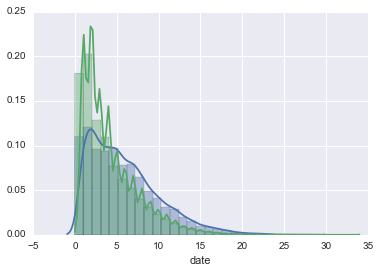

In [94]:
sns.distplot(df2[df2.vacant==1].date,bins=np.linspace(0,30,30));
sns.distplot(df2[df2.vacant==0].date,bins=np.linspace(0,30,30));

In [98]:
df2 = pd.merge(df.groupby('parcel').last(), tci[['vacant','ppn']], how='left',left_index=True, right_on='ppn')

In [87]:
df2[['type','vacant']].groupby('type').agg([sum,len])

vacant       
        sum    len
type              
al     1456  19320
fc     1928  15953
sa     1134   5482
t      4151  51346

In [106]:
d = df2[df2['type']=='fc']
d['year'] = d.date.apply(lambda x: x.year)

//anaconda/envs/vacancy/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [107]:
d[['year','vacant']].groupby('year').agg([sum,len])

vacant      
        sum   len
year             
2006     59   903
2007    103  1133
2008    191  1378
2009    159  1565
2010     90  1554
2011    144  1890
2012    169  1500
2013    187  1898
2014    600  2813
2015    226  1319

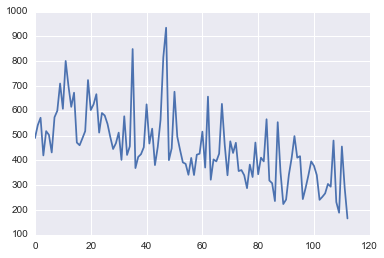

In [119]:
plt.plot(fc.set_index('date').groupby(['type']).resample('m', 'count'))

In [127]:
t = tci[tci.ppn.isin(fc[fc.date > dt.datetime(2015,3,1)].parcel)].vacant

In [128]:
sum(t),len(t)

(153, 828)

In [108]:
fc['year'] = fc['date']

,date,type,parcel
0,2006-10-03,fc,120-20-030
1,2006-10-03,fc,107-16-046
2,2006-10-03,fc,123-23-077
3,2006-10-03,fc,001-09-098
4,2006-10-03,fc,121-19-100
5,2006-10-03,fc,005-29-032
6,2006-10-03,fc,108-15-083
7,2006-10-03,fc,115-10-049
8,2006-10-03,fc,119-01-007
9,2006-10-03,fc,006-07-038
